In [1]:
"""
Advanced High-Risk Account Detection for Anti-Money Laundering
Uses Graph Neural Networks and Behavioral Feature Engineering
"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader as PyGDataLoader
import networkx as nx
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [ ]:
from tqdm import tqdm
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))  # Adjust as needed
from config import DATAPATH, SAMPLE_DATAPATH

In [3]:
# Load the entire dataset
df = pd.read_csv(DATAPATH)

# Filter by data range
df = df[df['Date'] < '2023-02-28']

In [6]:
print("\n" + "="*70)
print("TRANSACTION-LEVEL STATISTICS")
print("="*70)
print(f"Total transactions: {len(df):,}")
print(f"Suspicious transactions: {df['Is_laundering'].sum():,} ({df['Is_laundering'].mean()*100:.2f}%)")
print(f"Unique senders: {df['Sender_account'].nunique():,}")
print(f"Unique receivers: {df['Receiver_account'].nunique():,}")


TRANSACTION-LEVEL STATISTICS
Total transactions: 4,289,138
Suspicious transactions: 4,263 (0.10%)
Unique senders: 166,922
Unique receivers: 484,329


In [10]:
# Add and delete columns
df['DateTime'] = pd.to_datetime(df["Date"] + ' ' + df["Time"], format='%Y-%m-%d %H:%M:%S')

# df.drop(columns=['Laundering_type'], inplace=True)
df.drop(columns=['Time', 'Date'], inplace=True)

print("\nDate range:")
print(f"From: {df['DateTime'].min()}")
print(f"To: {df['DateTime'].max()}")


Date range:
From: 2022-10-07 10:35:19
To: 2023-02-27 23:59:52


## 3. Account-Level Feature Engineering

In [11]:
def extract_account_features(account, sent_txns, recv_txns):
    """
    Extract comprehensive behavioral features for an account
    """
    features = {}
    
    # === VOLUME & FREQUENCY FEATURES ===
    features['total_txns'] = len(sent_txns) + len(recv_txns)
    features['sent_count'] = len(sent_txns)
    features['recv_count'] = len(recv_txns)
    features['sent_recv_ratio'] = len(sent_txns) / (len(recv_txns) + 1)
    
    # === AMOUNT FEATURES ===
    features['total_sent_amount'] = sent_txns['Amount'].sum()
    features['total_recv_amount'] = recv_txns['Amount'].sum()
    features['avg_sent_amount'] = sent_txns['Amount'].mean() if len(sent_txns) > 0 else 0
    features['avg_recv_amount'] = recv_txns['Amount'].mean() if len(recv_txns) > 0 else 0
    features['std_sent_amount'] = sent_txns['Amount'].std() if len(sent_txns) > 1 else 0
    # features['std_recv_amount'] = recv_txns['Amount'].std() if len(recv_txns) > 1 else 0
    features['median_sent_amount'] = sent_txns['Amount'].median() if len(sent_txns) > 0 else 0
    features['median_recv_amount'] = recv_txns['Amount'].median() if len(recv_txns) > 0 else 0
    
    # === NETWORK FEATURES ===
    features['unique_senders'] = recv_txns['Sender_account'].nunique()
    features['unique_receivers'] = sent_txns['Receiver_account'].nunique()
    features['counterparty_diversity'] = features['unique_senders'] + features['unique_receivers']
    features['net_flow'] = features['total_recv_amount'] - features['total_sent_amount']
    
    # === BEHAVIORAL TEMPORAL FEATURES ===
    all_account_txns = pd.concat([sent_txns, recv_txns]).sort_values(by='DateTime').reset_index(drop=True)
    
    if len(all_account_txns) > 0:
        # Rolling window velocities for each transaction in history
        all_account_txns['txn_count_1h'] = all_account_txns.rolling(window='1h', on='DateTime')['Amount'].count()
        all_account_txns['txn_count_24h'] = all_account_txns.rolling(window='24h', on='DateTime')['Amount'].count()
        all_account_txns['txn_count_7d'] = all_account_txns.rolling(window='7d', on='DateTime')['Amount'].count()
        all_account_txns['txn_amount_7d'] = all_account_txns.rolling(window='7d', on='DateTime')['Amount'].sum()

        # Account-level features: max observed velocities
        features['max_txn_count_7d'] = all_account_txns['txn_count_7d'].max()
        features['max_txn_amount_7d'] = all_account_txns['txn_amount_7d'].max()

        # Baseline: typical daily activity (median is robust to outliers)
        baseline_daily_rate = all_account_txns['txn_count_24h'].median()

        # Behavioral change indicators
        features['velocity_anomaly_24h'] = all_account_txns['txn_count_24h'].max() / (baseline_daily_rate + 0.01)
        features['burst_ratio_1h_vs_7d'] = all_account_txns['txn_count_1h'].max() / (features['max_txn_count_7d'] / (7*24) + 0.01)
        
    else:
        # Set all behavioral features to 0 if no transactions
        behavioral_features = [
            'max_txn_count_7d', 'max_txn_amount_7d', 'velocity_anomaly_24h', 'burst_ratio_1h_vs_7d'
        ]
        for feat in behavioral_features:
            features[feat] = 0
    
    # === GEOGRAPHIC RISK FEATURES ===
    high_risk_countries = {'Mexico', 'Turkey', 'Morocco', 'UAE'}
    features['sent_to_high_risk'] = sent_txns['Receiver_bank_location'].isin(high_risk_countries).sum()
    features['recv_from_high_risk'] = recv_txns['Sender_bank_location'].isin(high_risk_countries).sum()
    features['high_risk_ratio'] = (features['sent_to_high_risk'] + features['recv_from_high_risk']) / \
                                 (features['total_txns'] + 1)
    
    # === PAYMENT TYPE RISK ===
    high_risk_payment_types = {'Cash', 'Cross-border'}
    features['high_risk_payment_count'] = sent_txns['Payment_type'].isin(high_risk_payment_types).sum()
    features['cash_usage_ratio'] = (sent_txns['Payment_type'] == 'Cash').sum() / (len(sent_txns) + 1)
    
    # === STRUCTURING INDICATORS ===
    # threshold = 10000
    # features['near_threshold_txns'] = sent_txns[(sent_txns['Amount'] > threshold * 0.8) & 
    #                                              (sent_txns['Amount'] < threshold)].shape[0]
    
    # === ROUND AMOUNT DETECTION ===
    features['round_amounts'] = sent_txns['Amount'].apply(lambda x: x % 1000 == 0).sum()
    
    return features

In [12]:
print("Extracting account-level features...")

accounts = list(set(df['Sender_account'].unique()) | set(df['Receiver_account'].unique()))
print(f"Total unique accounts: {len(accounts):,}")

Extracting account-level features...
Total unique accounts: 592,309


In [13]:
# Convert Amount to log scale
df['Amount'] = np.log1p(df['Amount'])
df.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,DateTime
0,8724731955,2769355426,7.286294,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022-10-07 10:35:19
1,1491989064,8401255335,8.702949,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out,2022-10-07 10:35:20
2,287305149,4404767002,9.570071,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out,2022-10-07 10:35:20
3,5376652437,9600420220,9.383957,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,2022-10-07 10:35:21
4,9614186178,3803336972,4.755743,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022-10-07 10:35:21


In [14]:
def process_features(accounts, idx):
    account_features = []
    account_labels = []
    account_ids = []

    for account in accounts:
        # if (i + 1) % 10000 == 0:
            # print(f"  Processed {i+1:,} / {len(accounts):,} accounts...")
        
        sent_txns = df[df['Sender_account'] == account]
        recv_txns = df[df['Receiver_account'] == account]
        
        features = extract_account_features(account, sent_txns, recv_txns)
        
        # Label: account is high-risk if involved in ANY suspicious transaction
        is_suspicious = (sent_txns['Is_laundering'].sum() > 0) or (recv_txns['Is_laundering'].sum() > 0)
        
        account_features.append(features)
        account_labels.append(1 if is_suspicious else 0)
        account_ids.append(account)


    np.save(f"tmp/features_temp_{idx}.npy", account_features)
    np.save(f"tmp/labels_temp_{idx}.npy", account_labels)
    np.save(f"tmp/ids_temp_{idx}.npy", account_ids)

In [15]:
# from joblib import Parallel, delayed


# batch_size = 100000

# batches_w_ids = [(i//batch_size, accounts[i:i + batch_size]) for i in range(0, len(accounts), batch_size)]

# Parallel(n_jobs=4, verbose=10)(
#     delayed(process_features)(batch, id) 
#     for id, batch in batches_w_ids
# )

In [16]:
# Load temporary file
batch_size = 100000

for batch in range(len(accounts)//batch_size + 1):
    print(f"Loading batch {batch}...")
    features = np.load(f"tmp/features_temp_{batch}.npy", allow_pickle=True)
    labels = np.load(f"tmp/labels_temp_{batch}.npy", allow_pickle=True)
    ids = np.load(f"tmp/ids_temp_{batch}.npy", allow_pickle=True)
    
    if batch == 0:
        all_features = features
        all_labels = labels
        all_ids = ids
    else:
        all_features = np.concatenate((all_features, features), axis=0)
        all_labels = np.concatenate((all_labels, labels), axis=0)
        all_ids = np.concatenate((all_ids, ids), axis=0)

Loading batch 0...
Loading batch 1...
Loading batch 2...
Loading batch 3...
Loading batch 4...
Loading batch 5...


In [17]:
features_df = pd.DataFrame(all_features.tolist(), index=all_ids)
labels_series = pd.Series(all_labels, index=all_ids, name='high_risk')

print("\nFeature extraction complete!")
print(f"Feature matrix shape: {features_df.shape}")
print(f"Number of features: {features_df.shape[1]}")


Feature extraction complete!
Feature matrix shape: (592309, 25)
Number of features: 25


In [18]:
# Display feature statistics
print("\n" + "="*70)
print("ACCOUNT-LEVEL STATISTICS")
print("="*70)
print(f"Total accounts: {len(features_df):,}")
print(f"High-risk accounts: {labels_series.sum():,} ({labels_series.mean()*100:.2f}%)")
print(f"\nFeature names:")
print(features_df.columns.tolist())


ACCOUNT-LEVEL STATISTICS
Total accounts: 592,309
High-risk accounts: 3,614 (0.61%)

Feature names:
['total_txns', 'sent_count', 'recv_count', 'sent_recv_ratio', 'total_sent_amount', 'total_recv_amount', 'avg_sent_amount', 'avg_recv_amount', 'std_sent_amount', 'median_sent_amount', 'median_recv_amount', 'unique_senders', 'unique_receivers', 'counterparty_diversity', 'net_flow', 'max_txn_count_7d', 'max_txn_amount_7d', 'velocity_anomaly_24h', 'burst_ratio_1h_vs_7d', 'sent_to_high_risk', 'recv_from_high_risk', 'high_risk_ratio', 'high_risk_payment_count', 'cash_usage_ratio', 'round_amounts']


In [19]:
features_df.head()

,total_txns,sent_count,recv_count,sent_recv_ratio,total_sent_amount,total_recv_amount,avg_sent_amount,avg_recv_amount,std_sent_amount,median_sent_amount,...,max_txn_count_7d,max_txn_amount_7d,velocity_anomaly_24h,burst_ratio_1h_vs_7d,sent_to_high_risk,recv_from_high_risk,high_risk_ratio,high_risk_payment_count,cash_usage_ratio,round_amounts
5465178121,12,12,0,12.0,102.962013,0.000000,8.580168,0.000000,0.003904,8.579117,...,12.0,102.962013,1.843318,24.561404,0,0,0.0,0,0.0,0.0
5662310411,5,0,5,0.0,0.000000,27.382606,0.000000,5.476521,0.000000,0.000000,...,2.0,11.668134,0.990099,45.652174,0,0,0.0,0,0.0,0.0
3426746385,3,0,3,0.0,0.000000,12.340875,0.000000,4.113625,0.000000,0.000000,...,2.0,9.271428,0.990099,45.652174,0,0,0.0,0,0.0,0.0
6849298455,2,0,2,0.0,0.000000,10.678643,0.000000,5.339322,0.000000,0.000000,...,1.0,5.674697,0.990099,62.686567,0,0,0.0,0,0.0,0.0
5676990492,3,2,1,1.0,22.269991,11.142599,11.134996,11.142599,0.010783,11.134996,...,1.0,11.142620,0.990099,62.686567,0,0,0.0,0,0.0,0.0


In [20]:
# Handle missing and infinite values
features_df = features_df.fillna(0)
features_df = features_df.replace([np.inf, -np.inf], 0)

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)
features_df_scaled = pd.DataFrame(features_scaled, columns=features_df.columns, index=features_df.index)

print("Features normalized!")
print(f"Scaled features shape: {features_df_scaled.shape}")

Features normalized!
Scaled features shape: (592309, 25)


### 5. Build Transaction Graph

In [21]:
def build_transaction_graph(df, account_features_df, account_labels):
    """
    Create graph where nodes are accounts and edges are transactions
    """
    print("Building transaction network graph...")
    
    # Create mapping of account to index
    accounts = list(account_features_df.index)
    account_to_idx = {acc: idx for idx, acc in enumerate(accounts)}
    
    # Build edges
    edge_index = []
    edge_attr = []
    
    for _, row in df.iterrows():
        sender = row['Sender_account']
        receiver = row['Receiver_account']
        
        if sender in account_to_idx and receiver in account_to_idx:
            sender_idx = account_to_idx[sender]
            receiver_idx = account_to_idx[receiver]
            
            edge_index.append([sender_idx, receiver_idx])
            
            # Edge features: amount, payment type encoded
            edge_features = [
                row['Amount'],
                1 if row['Payment_type'] == 'Cross-border' else 0,
            ]
            edge_attr.append(edge_features)
    
    # Convert to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    # Node features
    x = torch.tensor(account_features_df.values, dtype=torch.float)
    
    # Labels
    y = torch.tensor(account_labels.values, dtype=torch.long)
    
    # Create PyG data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    return data, account_to_idx

In [22]:
graph_data, account_to_idx = build_transaction_graph(df, features_df_scaled, labels_series)

print("\n" + "="*70)
print("GRAPH STATISTICS")
print("="*70)
print(f"Number of nodes (accounts): {graph_data.num_nodes:,}")
print(f"Number of edges (transactions): {graph_data.num_edges:,}")
print(f"Number of features per node: {graph_data.num_node_features}")
print(f"Average degree: {graph_data.num_edges / graph_data.num_nodes:.2f}")

Building transaction network graph...



GRAPH STATISTICS
Number of nodes (accounts): 592,309
Number of edges (transactions): 4,289,138
Number of features per node: 25
Average degree: 7.24


In [23]:
# Free up memory
# del df
# del all_features
# del features_df

### 6. Create Train/Validation/Test Split

In [24]:
# Stratified split
num_nodes = graph_data.num_nodes
indices = np.random.permutation(num_nodes)

train_size = int(0.7 * num_nodes)
val_size = int(0.15 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size+val_size]] = True
test_mask[indices[train_size+val_size:]] = True

print("Data split:")
print(f"  Train: {train_mask.sum():,} accounts ({train_mask.sum()/num_nodes*100:.1f}%)")
print(f"  Val:   {val_mask.sum():,} accounts ({val_mask.sum()/num_nodes*100:.1f}%)")
print(f"  Test:  {test_mask.sum():,} accounts ({test_mask.sum()/num_nodes*100:.1f}%)")

# Check class distribution in splits
print("\nClass distribution:")
print(f"  Train high-risk: {graph_data.y[train_mask].sum():,} ({graph_data.y[train_mask].float().mean()*100:.2f}%)")
print(f"  Val high-risk:   {graph_data.y[val_mask].sum():,} ({graph_data.y[val_mask].float().mean()*100:.2f}%)")
print(f"  Test high-risk:  {graph_data.y[test_mask].sum():,} ({graph_data.y[test_mask].float().mean()*100:.2f}%)")

Data split:
  Train: 414,616 accounts (70.0%)
  Val:   88,846 accounts (15.0%)
  Test:  88,847 accounts (15.0%)

Class distribution:
  Train high-risk: 2,480 (0.60%)
  Val high-risk:   567 (0.64%)
  Test high-risk:  567 (0.64%)


### 7. Define GNN Model

In [25]:
class GNN_AccountRiskDetector(nn.Module):
    """
    Graph Attention Network for account risk detection
    """
    
    def __init__(self, num_features, hidden_dim=128, num_heads=4, dropout=0.3):
        super(GNN_AccountRiskDetector, self).__init__()
        
        # Graph Attention Layers
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, dropout=dropout)
        self.conv3 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, concat=False, dropout=dropout)
        
        # Classification layers
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        
        self.dropout = nn.Dropout(dropout)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim * num_heads)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim * num_heads)
    
    def forward(self, x, edge_index):
        # GAT layers with attention
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.elu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = F.elu(x)
        x = self.dropout(x)
        
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        
        # Classification
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = GNN_AccountRiskDetector(
    num_features=graph_data.num_node_features,
    hidden_dim=128,
    num_heads=4,
    dropout=0.3
).to(device)

print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda

MODEL ARCHITECTURE
GNN_AccountRiskDetector(
  (conv1): GATConv(25, 128, heads=4)
  (conv2): GATConv(512, 128, heads=4)
  (conv3): GATConv(512, 128, heads=1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Total parameters: 356,386


### 8. Training

In [27]:
# Calculate class weights based on inverse frequency
def compute_class_weights(labels):
    """
    Compute class weights to handle imbalanced dataset
    """
    # Count samples per class
    n_samples = len(labels)
    n_classes = len(np.unique(labels))
    
    class_counts = np.bincount(labels)
    print(f"Class distribution:")
    print(f"  Normal (0): {class_counts[0]:,} ({class_counts[0]/n_samples*100:.2f}%)")
    print(f"  High-Risk (1): {class_counts[1]:,} ({class_counts[1]/n_samples*100:.2f}%)")
    
    # Compute weights (inverse frequency)
    # Formula: n_samples / (n_classes * class_count)
    class_weights = n_samples / (n_classes * class_counts)
    
    print(f"\nClass weights:")
    print(f"  Normal (0): {class_weights[0]:.4f}")
    print(f"  High-Risk (1): {class_weights[1]:.4f}")
    print(f"  Weight ratio: {class_weights[1]/class_weights[0]:.2f}x")
    
    return torch.FloatTensor(class_weights)

In [28]:
# Compute class weights from training data
class_weights = compute_class_weights(graph_data.y[train_mask].cpu().numpy())

# Move to device
class_weights = class_weights.to(device)

Class distribution:
  Normal (0): 412,136 (99.40%)
  High-Risk (1): 2,480 (0.60%)

Class weights:
  Normal (0): 0.5030
  High-Risk (1): 83.5919
  Weight ratio: 166.18x


In [29]:
# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Move data to device
graph_data = graph_data.to(device)

# %%
# Training function
def train_epoch():
    model.train()
    optimizer.zero_grad()
    
    out = model(graph_data.x, graph_data.edge_index)
    loss = criterion(out[train_mask], graph_data.y[train_mask])
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

# Evaluation function
@torch.no_grad()
def evaluate(mask):
    model.eval()
    
    out = model(graph_data.x, graph_data.edge_index)
    pred = out.argmax(dim=1)
    
    correct = (pred[mask] == graph_data.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    
    # Get probabilities for AUC
    probs = F.softmax(out[mask], dim=1)[:, 1].cpu().numpy()
    labels = graph_data.y[mask].cpu().numpy()
    
    auc = roc_auc_score(labels, probs)
    
    return acc, auc, pred[mask].cpu().numpy(), probs

In [30]:
# Training loop
print("\n" + "="*70)
print("TRAINING")
print("="*70)

epochs = 200
best_val_auc = 0
patience = 30
patience_counter = 0

train_losses = []
train_accs = []
train_aucs = []
val_accs = []
val_aucs = []

for epoch in range(epochs):
    loss = train_epoch()
    train_acc, train_auc, _, _ = evaluate(train_mask)
    val_acc, val_auc, _, _ = evaluate(val_mask)
    
    train_losses.append(loss)
    train_accs.append(train_acc)
    train_aucs.append(train_auc)
    val_accs.append(val_acc)
    val_aucs.append(val_auc)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1:03d} | Loss: {loss:.4f} | '
              f'Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f} | '
              f'Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}')
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\nBest validation AUC: {best_val_auc:.4f}")


TRAINING
Epoch 020 | Loss: 0.4428 | Train Acc: 0.7246 | Train AUC: 0.9042 | Val Acc: 0.7240 | Val AUC: 0.9031
Epoch 040 | Loss: 0.3559 | Train Acc: 0.7700 | Train AUC: 0.9363 | Val Acc: 0.7695 | Val AUC: 0.9322
Epoch 060 | Loss: 0.2929 | Train Acc: 0.8871 | Train AUC: 0.9570 | Val Acc: 0.8875 | Val AUC: 0.9546
Epoch 080 | Loss: 0.2576 | Train Acc: 0.9222 | Train AUC: 0.9633 | Val Acc: 0.9220 | Val AUC: 0.9639
Epoch 100 | Loss: 0.2396 | Train Acc: 0.9365 | Train AUC: 0.9624 | Val Acc: 0.9354 | Val AUC: 0.9632
Epoch 120 | Loss: 0.2221 | Train Acc: 0.9584 | Train AUC: 0.9716 | Val Acc: 0.9574 | Val AUC: 0.9708
Epoch 140 | Loss: 0.2143 | Train Acc: 0.9562 | Train AUC: 0.9764 | Val Acc: 0.9551 | Val AUC: 0.9757
Epoch 160 | Loss: 0.2087 | Train Acc: 0.9635 | Train AUC: 0.9803 | Val Acc: 0.9619 | Val AUC: 0.9792
Epoch 180 | Loss: 0.1962 | Train Acc: 0.9417 | Train AUC: 0.9851 | Val Acc: 0.9406 | Val AUC: 0.9824
Epoch 200 | Loss: 0.1798 | Train Acc: 0.9348 | Train AUC: 0.9859 | Val Acc: 0.934

In [31]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

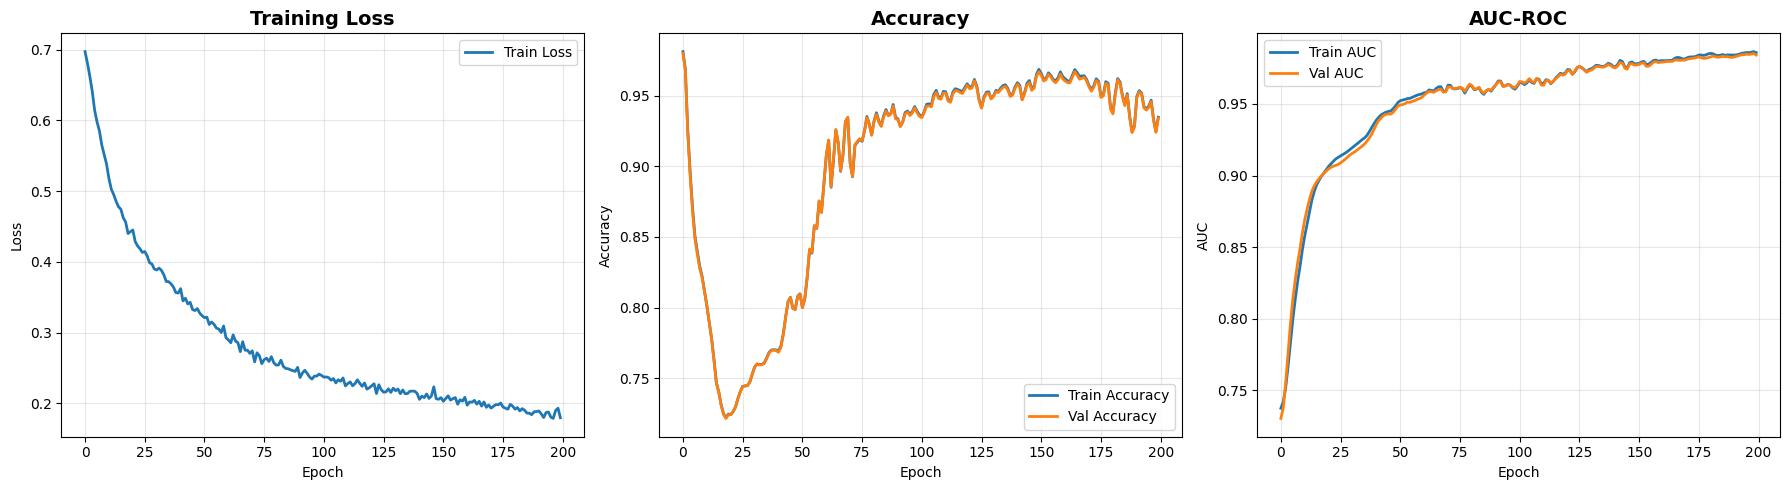

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Val Accuracy', linewidth=2)
axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

# AUC
axes[2].plot(train_aucs, label='Train AUC', linewidth=2)
axes[2].plot(val_aucs, label='Val AUC', linewidth=2)
axes[2].set_title('AUC-ROC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

test_acc, test_auc, test_pred, test_probs = evaluate(test_mask)
test_labels = graph_data.y[test_mask].cpu().numpy()

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_pred, 
                           target_names=['Normal Account', 'High-Risk Account'],
                           digits=4))


TEST SET EVALUATION

Test Accuracy: 0.9244
Test AUC-ROC: 0.9844

Classification Report:
                   precision    recall  f1-score   support

   Normal Account     0.9997    0.9242    0.9605     88280
High-Risk Account     0.0752    0.9594    0.1395       567

         accuracy                         0.9244     88847
        macro avg     0.5375    0.9418    0.5500     88847
     weighted avg     0.9938    0.9244    0.9552     88847



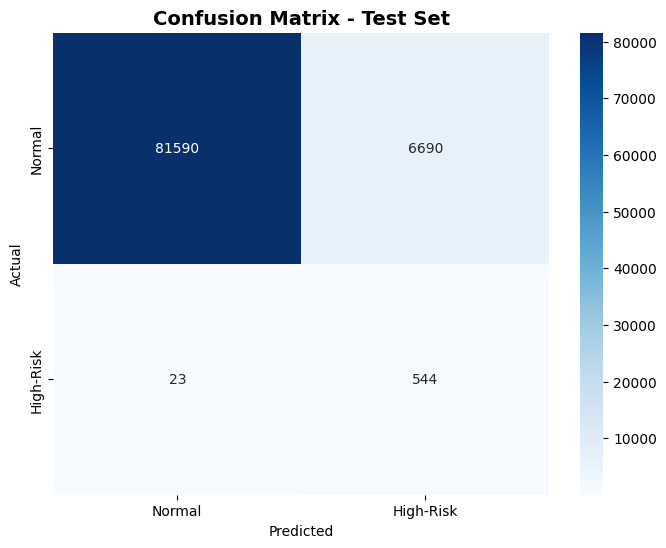

In [34]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'High-Risk'],
            yticklabels=['Normal', 'High-Risk'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

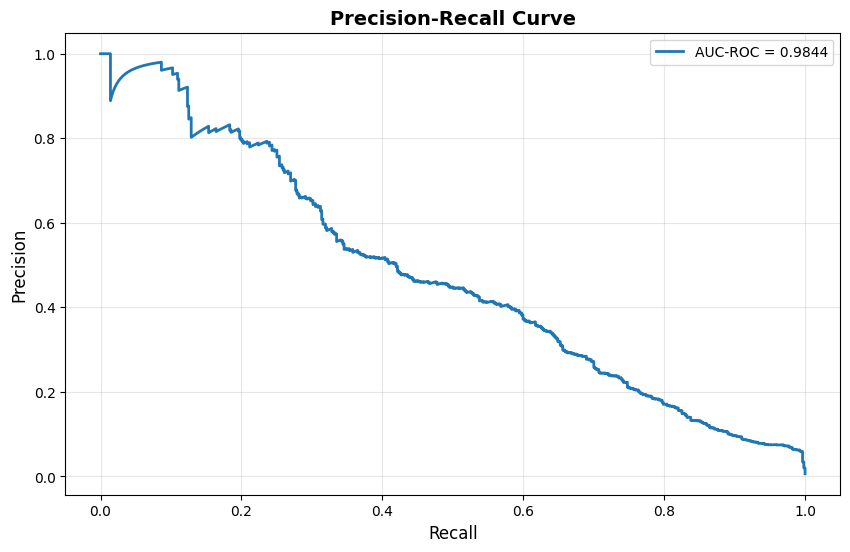

In [35]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(test_labels, test_probs)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'AUC-ROC = {test_auc:.4f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 11. Identify Top High-Risk Accounts

In [36]:
# Get all accounts with risk scores
idx_to_account = {v: k for k, v in account_to_idx.items()}
test_indices = torch.where(test_mask)[0].cpu().numpy()

high_risk_scores = list(zip(test_indices, test_probs))
high_risk_scores.sort(key=lambda x: x[1], reverse=True)

print("\n" + "="*70)
print("TOP 20 HIGH-RISK ACCOUNTS")
print("="*70)
print(f"{'Rank':<6} {'Account ID':<20} {'Risk Score':<12} {'Actual Label':<15} {'Predicted':<12}")
print("-" * 70)

for i, (idx, score) in enumerate(high_risk_scores[:20], 1):
    account_id = idx_to_account[idx]
    test_idx_position = list(test_indices).index(idx)
    actual_label = "HIGH-RISK" if test_labels[test_idx_position] == 1 else "NORMAL"
    predicted = "HIGH-RISK" if test_pred[test_idx_position] == 1 else "NORMAL"
    
    print(f"{i:<6} {str(account_id):<20} {score:<12.4f} {actual_label:<15} {predicted:<12}")


TOP 20 HIGH-RISK ACCOUNTS
Rank   Account ID           Risk Score   Actual Label    Predicted   
----------------------------------------------------------------------
1      3627634017           0.9996       HIGH-RISK       HIGH-RISK   
2      9382188772           0.9995       HIGH-RISK       HIGH-RISK   
3      6562075226           0.9993       HIGH-RISK       HIGH-RISK   
4      948776751            0.9993       HIGH-RISK       HIGH-RISK   
5      7504588448           0.9993       HIGH-RISK       HIGH-RISK   
6      5866257101           0.9993       HIGH-RISK       HIGH-RISK   
7      6993016746           0.9993       HIGH-RISK       HIGH-RISK   
8      63528476             0.9993       HIGH-RISK       HIGH-RISK   
9      4258238782           0.9992       NORMAL          HIGH-RISK   
10     8310992698           0.9992       HIGH-RISK       HIGH-RISK   
11     5454032169           0.9992       HIGH-RISK       HIGH-RISK   
12     9231160979           0.9992       HIGH-RISK       HIGH-

### 12. Feature Importance Analysis

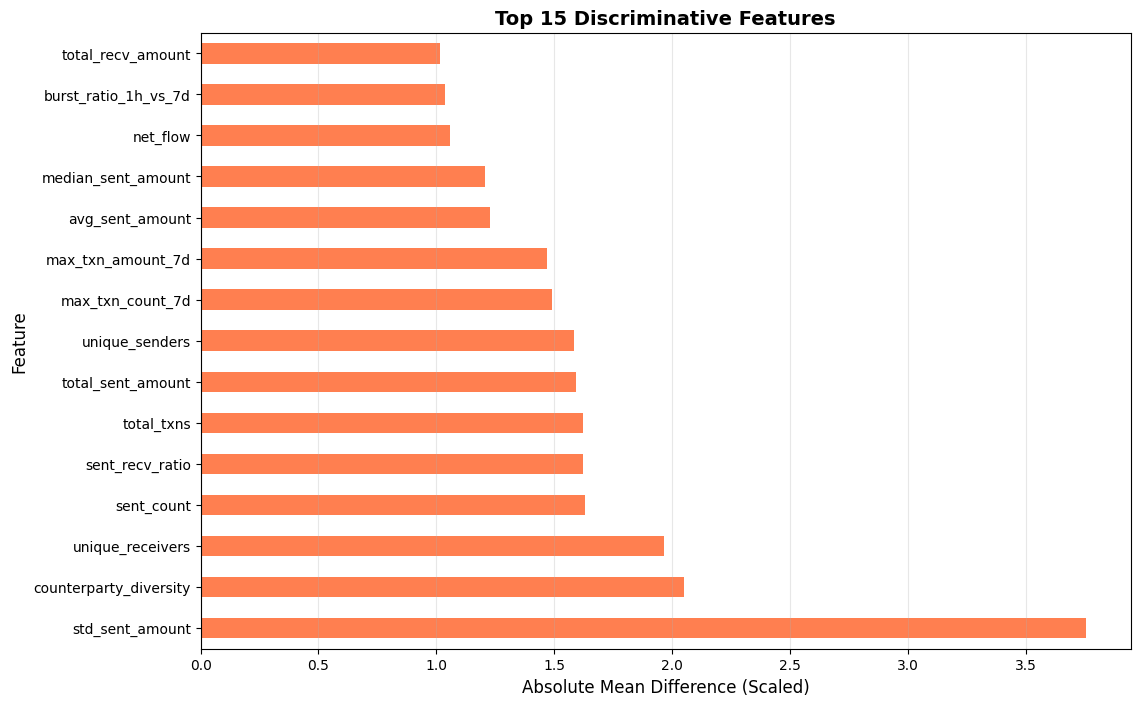

In [37]:
# Get feature importance by analyzing predictions on high-risk vs normal accounts
high_risk_mask = (graph_data.y == 1)
normal_mask = (graph_data.y == 0)

high_risk_features = features_df_scaled[high_risk_mask.cpu().numpy()].mean()
normal_features = features_df_scaled[normal_mask.cpu().numpy()].mean()

feature_diff = (high_risk_features - normal_features).abs().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_diff.head(15).plot(kind='barh', color='coral')
plt.title('Top 15 Discriminative Features', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Mean Difference (Scaled)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout
plt.show()

### 13. Account Profile Analysis

In [38]:
# %%
def analyze_account(account_id):
    """
    Detailed analysis of a specific account
    """
    if account_id not in account_to_idx:
        print(f"Account {account_id} not found in dataset")
        return
    
    idx = account_to_idx[account_id]
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        prob = F.softmax(out[idx], dim=0)[1].item()
        pred = out[idx].argmax().item()
    
    actual = graph_data.y[idx].item()
    
    print("\n" + "="*70)
    print(f"ACCOUNT ANALYSIS: {account_id}")
    print("="*70)
    print(f"Risk Score: {prob:.4f}")
    print(f"Predicted: {'HIGH-RISK' if pred == 1 else 'NORMAL'}")
    print(f"Actual: {'HIGH-RISK' if actual == 1 else 'NORMAL'}")
    
    # Get account features
    account_features = features_df.loc[account_id]
    
    print("\n--- Transaction Profile ---")
    print(f"Total Transactions: {int(account_features['total_txns'])}")
    print(f"Sent: {int(account_features['sent_count'])} | Received: {int(account_features['recv_count'])}")
    print(f"Total Sent Amount: ${account_features['total_sent_amount']:,.2f}")
    print(f"Total Received Amount: ${account_features['total_recv_amount']:,.2f}")
    
    print("\n--- Behavioral Patterns ---")
    # print(f"Max Daily Transactions: {int(account_features['max_daily_txn_count'])}")
    # print(f"Avg Daily Transactions: {account_features['avg_daily_txn_count']:.2f}")
    # print(f"Max Weekly Transactions: {int(account_features['max_weekly_txn_count'])}")
    # print(f"Max Monthly Transactions: {int(account_features['max_monthly_txn_count'])}")
    # print(f"Daily Velocity Ratio: {account_features['daily_velocity_ratio']:.2f}")
    # print(f"Active Days Ratio: {account_features['active_days_ratio']:.2%}")
    
    print("\n--- Risk Indicators ---")
    print(f"High-Risk Geography: {int(account_features['sent_to_high_risk'])} transactions")
    print(f"Cash Usage Ratio: {account_features['cash_usage_ratio']:.2%}")
    print(f"Near-Threshold Transactions: {int(account_features['near_threshold_txns'])}")
    print(f"Round Amounts: {int(account_features['round_amounts'])}")
    
    print("\n--- Network Activity ---")
    print(f"Unique Receivers: {int(account_features['unique_receivers'])}")
    print(f"Unique Senders: {int(account_features['unique_senders'])}")
    print(f"Counterparty Diversity: {int(account_features['counterparty_diversity'])}")
    
    # Get actual transactions
    sent_txns = df[df['Sender_account'] == account_id]
    recv_txns = df[df['Receiver_account'] == account_id]
    
    if len(sent_txns) > 0:
        print("\n--- Recent Sent Transactions (Top 5 by Amount) ---")
        print(sent_txns.nlargest(5, 'Amount')[['Timestamp', 'Receiver_account', 'Amount', 
                                                 'Payment_type', 'Is_Suspicious']])
    
    if len(recv_txns) > 0:
        print("\n--- Recent Received Transactions (Top 5 by Amount) ---")
        print(recv_txns.nlargest(5, 'Amount')[['Timestamp', 'Sender_account', 'Amount', 
                                                'Payment_type', 'Is_Suspicious']])


In [39]:
# Example: Analyze a high-risk account
if len(high_risk_scores) > 0:
    top_high_risk_idx = high_risk_scores[0][0]
    top_high_risk_account = idx_to_account[top_high_risk_idx]
    analyze_account(top_high_risk_account)


ACCOUNT ANALYSIS: 3627634017
Risk Score: 0.9996
Predicted: HIGH-RISK
Actual: HIGH-RISK

--- Transaction Profile ---
Total Transactions: 8
Sent: 8 | Received: 0
Total Sent Amount: $78.04
Total Received Amount: $0.00

--- Behavioral Patterns ---

--- Risk Indicators ---
High-Risk Geography: 0 transactions
Cash Usage Ratio: 0.00%


KeyError: 'near_threshold_txns'

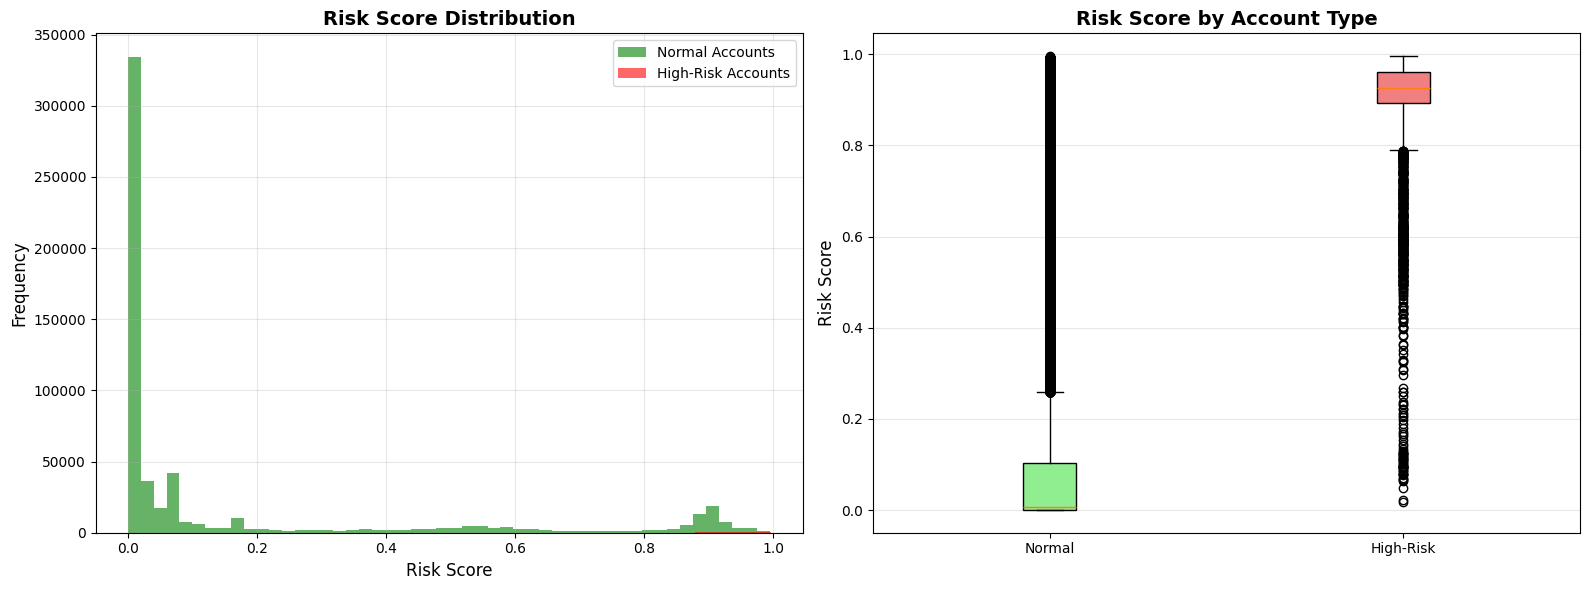

In [64]:
# ## 14. Risk Score Distribution

# %%
# Get all risk scores
model.eval()
with torch.no_grad():
    out = model(graph_data.x, graph_data.edge_index)
    all_probs = F.softmax(out, dim=1)[:, 1].cpu().numpy()
all_labels = graph_data.y.cpu().numpy()

# Plot risk score distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(all_probs[all_labels == 0], bins=50, alpha=0.6, label='Normal Accounts', color='green')
axes[0].hist(all_probs[all_labels == 1], bins=50, alpha=0.6, label='High-Risk Accounts', color='red')
axes[0].set_xlabel('Risk Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Risk Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
data_for_box = [all_probs[all_labels == 0], all_probs[all_labels == 1]]
bp = axes[1].boxplot(data_for_box, labels=['Normal', 'High-Risk'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Risk Score', fontsize=12)
axes[1].set_title('Risk Score by Account Type', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 15. Model Performance by Risk Threshold

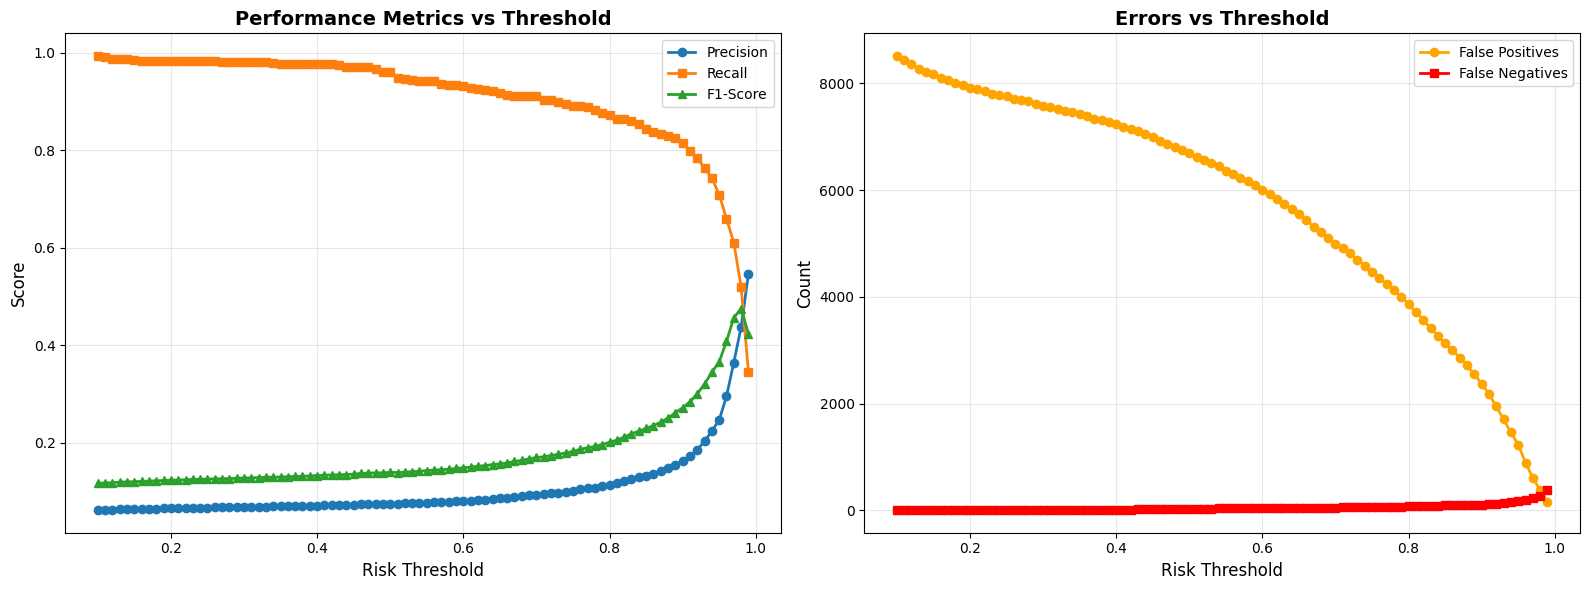


Threshold Analysis:
 threshold  precision   recall       f1  tp   fp  fn
      0.10   0.062032 0.992945 0.116769 563 8513   4
      0.11   0.062438 0.991182 0.117475 562 8439   5
      0.12   0.062766 0.987654 0.118031 560 8362   7
      0.13   0.063377 0.987654 0.119111 560 8276   7
      0.14   0.063767 0.987654 0.119799 560 8222   7
      0.15   0.063939 0.984127 0.120077 558 8169   9
      0.16   0.064348 0.982363 0.120785 557 8099  10
      0.17   0.064670 0.982363 0.121351 557 8056  10
      0.18   0.065017 0.982363 0.121962 557 8010  10
      0.19   0.065376 0.982363 0.122593 557 7963  10
      0.20   0.065769 0.982363 0.123285 557 7912  10
      0.21   0.065972 0.982363 0.123640 557 7886  10
      0.22   0.066231 0.982363 0.124095 557 7853  10
      0.23   0.066587 0.982363 0.124720 557 7808  10
      0.24   0.066763 0.982363 0.125028 557 7786  10
      0.25   0.067012 0.982363 0.125465 557 7755  10
      0.26   0.067319 0.982363 0.126004 557 7717  10
      0.27   0.067402 0.9

In [41]:
# Analyze performance at different thresholds
thresholds = np.arange(0.1, 1.0, 0.01)
threshold_metrics = []

for threshold in thresholds:
    test_pred_threshold = (test_probs >= threshold).astype(int)
    
    # Calculate metrics
    tp = ((test_pred_threshold == 1) & (test_labels == 1)).sum()
    tn = ((test_pred_threshold == 0) & (test_labels == 0)).sum()
    fp = ((test_pred_threshold == 1) & (test_labels == 0)).sum()
    fn = ((test_pred_threshold == 0) & (test_labels == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    threshold_metrics.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Precision-Recall-F1
axes[0].plot(threshold_df['threshold'], threshold_df['precision'], 
             marker='o', label='Precision', linewidth=2)
axes[0].plot(threshold_df['threshold'], threshold_df['recall'], 
             marker='s', label='Recall', linewidth=2)
axes[0].plot(threshold_df['threshold'], threshold_df['f1'], 
             marker='^', label='F1-Score', linewidth=2)
axes[0].set_xlabel('Risk Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Metrics vs Threshold', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# False Positives vs False Negatives
axes[1].plot(threshold_df['threshold'], threshold_df['fp'], 
             marker='o', label='False Positives', linewidth=2, color='orange')
axes[1].plot(threshold_df['threshold'], threshold_df['fn'], 
             marker='s', label='False Negatives', linewidth=2, color='red')
axes[1].set_xlabel('Risk Threshold', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Errors vs Threshold', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nThreshold Analysis:")
print(threshold_df.to_string(index=False))

### 17. Summary and Key Findings

In [42]:
# %%
print("\n" + "="*70)
print("SUMMARY OF RESULTS")
print("="*70)

print(f"\n📊 Dataset Statistics:")
print(f"   • Total Accounts: {len(features_df):,}")
print(f"   • High-Risk Accounts: {labels_series.sum():,} ({labels_series.mean()*100:.2f}%)")
print(f"   • Total Transactions: {len(df):,}")
print(f"   • Graph Edges: {graph_data.num_edges:,}")

print(f"\n🎯 Model Performance (Test Set):")
print(f"   • Accuracy: {test_acc:.4f}")
print(f"   • AUC-ROC: {test_auc:.4f}")

# Calculate additional metrics
test_cm = confusion_matrix(test_labels, test_pred)
tn, fp, fn, tp = test_cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"   • Precision: {precision:.4f}")
print(f"   • Recall: {recall:.4f}")
print(f"   • F1-Score: {f1:.4f}")
print(f"   • False Positive Rate: {fp/(fp+tn):.4f}")
print(f"   • False Negative Rate: {fn/(fn+tp):.4f}")

print(f"\n🔍 Top Risk Indicators:")
top_features = feature_diff.head(5)
for i, (feat, val) in enumerate(top_features.items(), 1):
    print(f"   {i}. {feat}: {val:.4f}")

print(f"\n💡 Key Insights:")
print(f"   • Behavioral velocity features are strong discriminators")
print(f"   • Network patterns (counterparty diversity) are important")
print(f"   • Geographic and payment type risk contribute to detection")
print(f"   • Graph structure captures money flow relationships")

print("\n" + "="*70)
print("Analysis Complete! ✅")
print("="*70)


SUMMARY OF RESULTS

📊 Dataset Statistics:
   • Total Accounts: 592,309
   • High-Risk Accounts: 3,614 (0.61%)
   • Total Transactions: 4,289,138
   • Graph Edges: 4,289,138

🎯 Model Performance (Test Set):
   • Accuracy: 0.9244
   • AUC-ROC: 0.9844
   • Precision: 0.0752
   • Recall: 0.9594
   • F1-Score: 0.1395
   • False Positive Rate: 0.0758
   • False Negative Rate: 0.0406

🔍 Top Risk Indicators:
   1. std_sent_amount: 3.7581
   2. counterparty_diversity: 2.0490
   3. unique_receivers: 1.9657
   4. sent_count: 1.6320
   5. sent_recv_ratio: 1.6244

💡 Key Insights:
   • Behavioral velocity features are strong discriminators
   • Network patterns (counterparty diversity) are important
   • Geographic and payment type risk contribute to detection
   • Graph structure captures money flow relationships

Analysis Complete! ✅
